> [English version](../docs/chapter05_defense_strategies.md)

# Стратегии защиты

Как мы показали, после того как злоумышленник получает доступ к системе машинного обучения, он может использовать различные тактики для отравления датасета. Это может подорвать целостность модели и привести к злонамеренному поведению, такому как неверные предсказания или даже эксплуатация модели. Так как же защититься от этих атак и снизить риски?

Хотя традиционные методы защиты, такие как доступ с наименьшими привилегиями, шифрование и хеширование данных, являются важными, комплексный подход должен также включать интеграцию этих защитных механизмов с операциями машинного обучения (MLOps). Например, платформы, такие как AWS SageMaker, предоставляют автоматизированный мониторинг, отслеживание и аудит, что помогает обеспечить контроль доступа и улучшить видимость.

Однако отравление данных и аномальные данные в вашем датасете требуют специализированных стратегий. В этом разделе мы рассмотрим несколько стратегий на уровне датасета для защиты от таких атак. В частности, мы обсудим статистические методы и алгоритмы машинного обучения для выявления и устранения выбросов и аномалий в данных.

## 1. Загрузка данных

Прежде чем начать работу с датасетом, важно инициализировать нашу среду и импортировать необходимые библиотеки. Мы также убедимся, что можем правильно загрузить датасет с помощью локального скрипта.

In [143]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [145]:
from modules.load_dataset import load_dataset
dataset = load_dataset('spam_ham_dataset_poisoned.csv')
dataset.head()

,Unnamed: 0,label,text,label_num
0,3581,spam,Subject: credit watch list - - week of 11 / 5 ...,1
1,693,spam,"Subject: wellheads\r\ndaren , cody has a new w...",1
2,4005,ham,Subject: re : gussing movies for paliourg\r\np...,0
3,1439,spam,"Subject: hpl nom for august 23 , 2000\r\n( see...",1
4,445,spam,Subject: weekend noms will either of you forwa...,1


## 2. Обработка данных

В этом разделе мы рассмотрим шаги по очистке и предобработке сырых текстовых данных с использованием кастомного класса `CleanText`, который был представлен ранее в основном ноутбуке.

In [146]:
from modules.clean_text import CleanText

cleaner = CleanText()
dataset['text_cleaned'] = dataset['text'].apply(cleaner.on_clean)

## 3. Векторизация

После очистки сырых текстовых данных на предыдущем шаге следующим этапом будет преобразование этих данных в формат, который могут понять модели машинного обучения. 

In [147]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.decomposition import  PCA
vectorizer = TfidfVectorizer(max_features=6000)
X_tfidf=vectorizer.fit_transform(dataset['text_cleaned'])
X_tfidf

<5688x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 308328 stored elements in Compressed Sparse Row format>

## 4. Главный компонентный анализ (PCA)

Главный компонентный анализ (PCA) — это широко используемая техника для уменьшения размерности, которая преобразует высокоразмерные данные в более низкоразмерное пространство, сохраняя как можно больше дисперсии. Проецируя данные на направления (главные компоненты), которые захватывают наибольшую дисперсию, PCA упрощает сложные наборы данных, делая их более удобными для анализа и визуализации.

В этом разделе мы используем PCA для визуализации векторизованных данных из предыдущего раздела, что позволяет лучше понять структуру данных, выявить возможные выбросы и, возможно, определить наличие загрязненных данных в датасете.


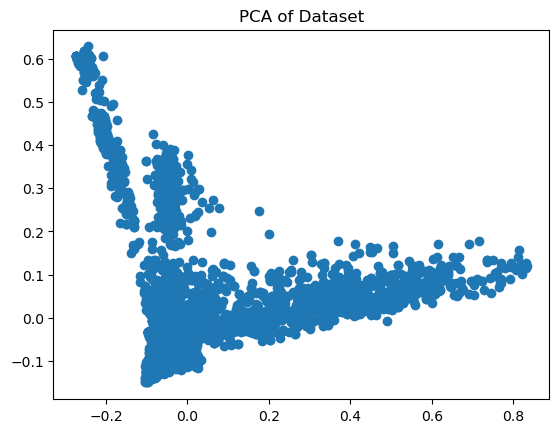

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA of Dataset")
plt.show()

> Отравленные данные, введенные через целенаправленные атаки, обычно образуют плотные регионы или кластеры в пространстве PCA. Эти точки разработаны так, чтобы выглядеть схожими друг с другом и образовывать отчетливый паттерн, что облегчает их обнаружение. После того как эти кластеры будут обнаружены, можно будет предпринять дополнительные шаги для их удаления или коррекции.

## Изоляционный лес: Обнаружение аномалий

**Изоляционный лес (Isolation Forest)** — это алгоритм для обнаружения аномалий, который изолирует аномалии путем рекурсивного разбиения данных. Он строит несколько деревьев решений, и аномалии обнаруживаются на основе более коротких путей, так как такие точки легче изолировать. Это делает алгоритм особенно эффективным для высокоразмерных данных, таких как обнаружение спама.

Мы применяем **Изоляционный лес** к **Spambase** датасету для выявления потенциальных выбросов или загрязненных данных, с целью очистить датасет перед обучением модели.



In [149]:
from sklearn.ensemble import  IsolationForest
from sklearn.metrics import accuracy_score, classification_report
model = IsolationForest(contamination=0.05)
X = X_tfidf.toarray()
model.fit(X)

IsolationForest(contamination=0.05)

## Отчет о классификации с изоляционным лесом

Теперь давайте визуализируем предсказания и используем `decision_function`, чтобы вычислить аномальный балл, который критичен для построения диаграммы рассеяния. Это поможет нам понять, насколько эффективно модель выявляет аномалии.

> **Как правило**, значение **recall** является важным показателем при оценке моделей обнаружения аномалий. **Однако**, в случае отравленного датасета, значение recall становится еще более критичным. Низкое значение recall указывает на то, что аномалии (например, загрязненные данные) не были обнаружены, что является тревожным сигналом. Это должно стать поводом для расследования и устранения аномальных или отравленных данных до продолжения обучения модели.


In [150]:
predictions=model.predict(X)
dataset['anomaly_score'] = model.decision_function(X)
predictions[predictions==1]=0
predictions[predictions==-1]=1
dataset['predicted_class'] = predictions
print("Accuracy in finding anomaly:",accuracy_score(dataset['label_num'], predictions))
print("Classification Report with Isolation Forest:")
print(classification_report(dataset['label_num'], predictions))

dataset['predicted_class'].value_counts()

Accuracy in finding anomaly: 0.685478199718706
Classification Report with Isolation Forest:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      3842
           1       0.60      0.09      0.16      1846

    accuracy                           0.69      5688
   macro avg       0.65      0.53      0.48      5688
weighted avg       0.66      0.69      0.60      5688



predicted_class
0    5405
1     283
Name: count, dtype: int64

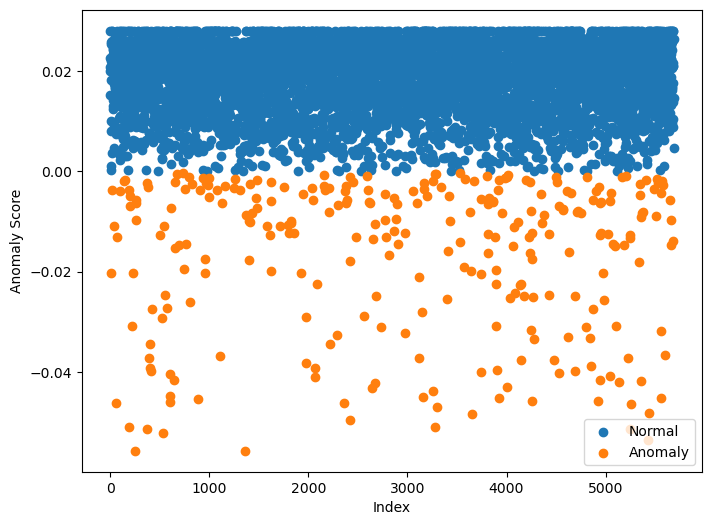

In [ ]:
plt.figure(figsize=(8, 6))
normal = dataset[dataset['predicted_class'] == 0]
anomaly = dataset[dataset['predicted_class'] == 1]
plt.scatter(normal.index, normal['anomaly_score'],label='Normal',
               )
plt.scatter(anomaly.index, y=anomaly['anomaly_score'],label='Anomaly')
plt.xlabel('Instance Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

### СПИСОК ИСПОЛЬЗОВАННОЙ ЛИТЕРАТУРЫ

1. Сотиропулос, Дж. Атаки на искусственный интеллект, методы смягчения и стратегии защиты [электронный ресурс] – URL https://dl.acm.org/doi/10.1145/1541880.1541882 (30.11.2024)

2. Scikit-learn. Документация: Изоляционный лес [электронный ресурс] – URL https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html (30.11.2024)


